<h1>Stock Market Analysis</h1>

<h1> Table of Contents </h1>

1. [Overview and Motivation](#intro)
2. [Initial Questions](#questions)
3. [Related Work](#previous-study)
4. [Understand the Dataset and Get Data](#dataset)
5. [Exploratory Data Analysis](#eda)
6. [Prediction Model](#modeling)
7. [Evaluation and Analysis](#analysis)
8. [References](#references)

<hr>

## Overview and Motivation: <a name="intro"></a>

<p style='text-align: justify; margin-right: 20px'> Investing the "extra cash" once a person has a steady source of income and solid emergency fund is a truly mind-boggling matter. Should the money be kept in savings account or should it be invested in real estate, bonds, mutual funds or stocks? Inarguably, the matter of deciding the best place to stash the cash is not always easy and as quoted from <em>Warren Buffet</em>, who is regarded as the most successful investor in the world, <em><b>Do not put all eggs in one basket</b></em>. According to a report published by <em>Franklin Templeton Investments</em> (2020), stocks have averaged a 10.59% one-year return over the last half century (ended December 31, 2019), therefore they provide the highest potential returns compared with other "baskets". However, stocks tend to be the most volatile investments thus carrying a higher degree of risk in comparison to other investment opportunities. </p>

<p style='text-align: justify; margin-right: 20px'> This project is about <em>forecasting time series data using machine learning algorithms</em> as the stock market data itself e.g. daily opening and closing stock prices are time-series in nature. In addition to the analysis, do note that stock price is also affected by the news about the company and other factors like demonetization or merger/demerger of the companies (which can be deciphered by applying Natural Language Processing (NLP) to the financial news but this will not be convered in the project) and there are certain intangible factors as well which can often be impossible to predict beforehand e.g. Covid-19 Pandemic. </p>

<hr>

## Initial Questions:  <a name="questions"></a>

So, stocks investment seems promising but if I want to start investing, these are the questions that would come to my mind, such as:
* <b>What is the best stock to invest in right now?</b>
* <b>Should I buy now or wait?</b>

Our goal is to predict the  closing price of the selected stock at a given date.
    
<hr>

## Related Work: <a name="previous-study"></a>

## Understand the Dataset and Get Data: <a name="dataset"></a>

Variables in the dataset:


| Variables    | Description                                                        |
| :----------- | :----------------------------------------------------------------- |
| Date         | The date at which the stock is traded                              |
| Open         | The staring price at which the stock is traded on a particular day |
| High         | The maximum price of the share for the day                         |
| Low          | The minimum price of the share for the day                         |
| Close        | The final price at which the stock is traded on a particular day   |
| Volume       | The number of shares bought or sold for the day                    |



In [39]:
# import libraries to ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# import general libraries
import numpy as np
import pandas as pd
import math
import os

# import libaries for visualisation and define setting
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pandas.plotting import lag_plot
plt.style.use("seaborn-white")
plt.rcParams["figure.figsize"]=20,12
plt.rcParams.update({'font.size': 14})

# import libraries for time series analysis
from datetime import datetime, date, timedelta
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.offsets import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# import libraries for modeling
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential 
from keras.layers import Dense, LSTM

In [2]:
# define function to read file(s):

os.chdir('.\stocks')

def read_file(abbr):
    
    file_list = []    
    for file in os.listdir():
        if file.endswith('.csv'):
            df = pd.read_csv(file,)
            df['Symbol'] = file.replace(".csv", "")
            file_list.append(df)
    data = pd.concat(file_list, axis=0, ignore_index=True)
    if abbr == " ":
        data = data
    else:
        data = data[data['Symbol'].isin(abbr)]
    
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Symbol']
    return(data)


In [3]:
# read data
stock_data = read_file(['AAPL', 'AMZN', 'FB', 'ISRG'])

In [4]:
# to check: display the first five rows of data
stock_data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,Symbol
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400.0,AAPL
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200.0,AAPL
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000.0,AAPL
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400.0,AAPL
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400.0,AAPL


In [5]:
# to check: display the last five rows of data
stock_data.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume,Symbol
29132,2020-02-27,550.390015,560.489990,544.179993,544.619995,544.619995,1066600.0,ISRG
29133,2020-02-28,527.909973,536.849976,518.559998,533.960022,533.960022,1943200.0,ISRG
29134,2020-03-02,535.950012,559.580017,532.219971,559.070007,559.070007,947500.0,ISRG
29135,2020-03-03,556.719971,575.000000,543.789978,558.270020,558.270020,1027200.0,ISRG
29136,2020-03-04,568.000000,583.719971,563.000000,582.900024,582.900024,734000.0,ISRG


## Exploratory Data Analysis <a name="eda"></a>

In Time Series Analysis, the data must be indexed by timestamps, thus we will begin by creating a datetime index for the dataframe. 

In [6]:
# set date as index
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')
stock_data.set_index('Date', inplace=True)

In [7]:
# to check: display a random sampling of 5 rows
stock_data.sample(5, random_state=0)

,Open,High,Low,Close,Adj_Close,Volume,Symbol
Date,,,,,,,
2009-03-03,62.750000,63.290001,61.299999,61.700001,61.700001,9691600.0,AMZN
2000-12-11,1.084821,1.098214,1.062500,1.084821,0.941669,83127800.0,AAPL
2015-09-29,89.099998,90.059998,85.720001,86.669998,86.669998,42281800.0,FB
2013-07-24,26.320000,26.530001,26.049999,26.510000,26.510000,82635600.0,FB
2009-09-29,86.476669,86.669998,84.973335,85.529999,85.529999,1284600.0,ISRG


The closing price `Close` and the adjusted closing price `Adj_Close` refer to the different ways of stocks being valuated. The later represents a more complex analysis that using the closing price as a starting point.
    
> <li> The <b>closing price</b> is literally the price of a particular stock at the close of a trading day. </li>
> <li> The <b>adjusted closing price</b> taking takes into account factors such as dividends, stock splits and new stock      offerings. 
    
    
Seeing that `Adj_Close` represents a more accurate reflection of a stock's value, we will make this variable as the target variable. </p>

In [8]:
# subset Adj_Close from stock_data:
df_adj_close = stock_data[['Adj_Close', 'Symbol']]

In [9]:
# to check: display a random sampling of 5 rows
df_adj_close.sample(5, random_state=0)

,Adj_Close,Symbol
Date,,
2009-03-03,61.700001,AMZN
2000-12-11,0.941669,AAPL
2015-09-29,86.669998,FB
2013-07-24,26.510000,FB
2009-09-29,85.529999,ISRG


### Line Plot: the first step to comprehend the data

The best way to understand the data is through visualisation. Let's plot the daily adjusted closing price of the selected companies using line charts and then compare each performances throughout the years.

Text(0.5, 1.0, 'Daily Adjusted Closing Price of AAPL, AMZN, FB, and ISRG')

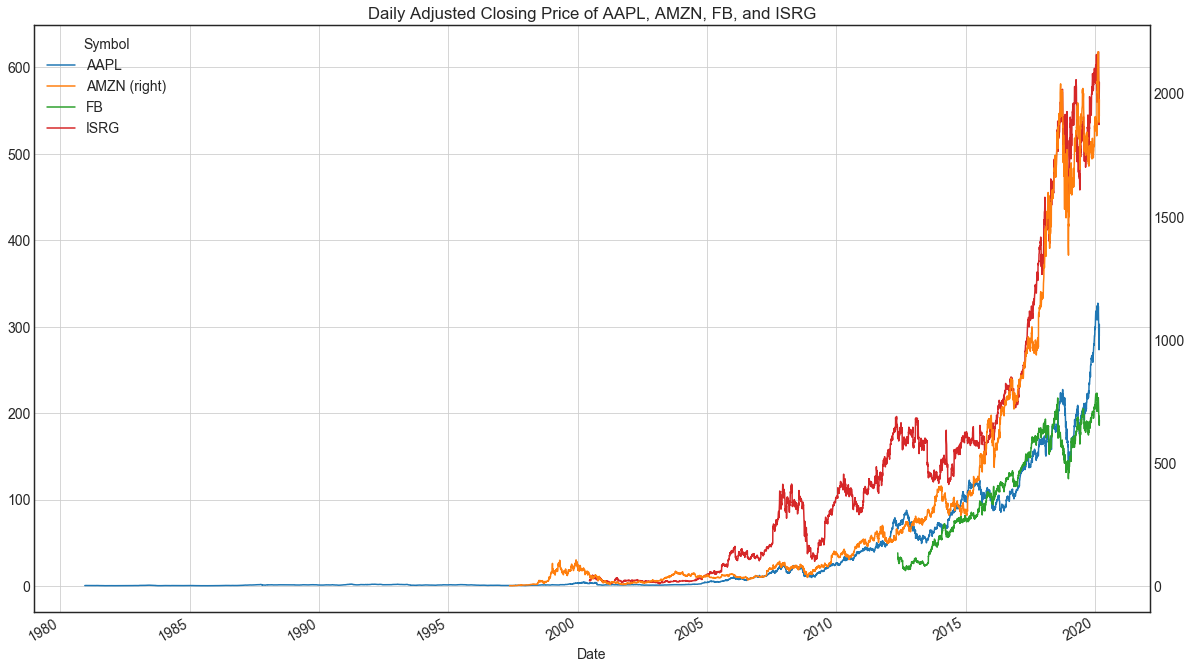

In [40]:
# reshape the data frame for visualisation:
df_adj_close_viz = df_adj_close.pivot(columns='Symbol')
df_adj_close_viz.columns = df_adj_close_viz.columns.droplevel(0)
df_adj_close_viz.plot(secondary_y=["AMZN"], grid=True)
plt.title('Daily Adjusted Closing Price of AAPL, AMZN, FB, and ISRG')

In [11]:
# to check: display a random sampling of 5 rows
# df_adj_close_viz.sample(5, random_state=0)

From the visualisation, it is evident that these stocks share a common `end_date` i.e. 020-03-04 whereas the `start_date` is differs from each other. 

### Missing Data Analysis
Although the data is claimed to have 'daily' frequency, we need to check if this is true or not. Is there any missing trading days in the data?

In [12]:
# is there any missing datapoints in the data? 
df_adj_close.isna().sum()

Adj_Close    0
Symbol       0
dtype: int64

In [13]:
# define function to identify the missing trading day(s) for each company:

def missing_dates(data):
    
    grouped = data.groupby('Symbol')
    output = []
    for key, value in grouped:
        
        data_dates = value.index.sort_values()
        trading_days = len(data_dates)
        
        start_date = data_dates[0]
        end_date = data_dates[-1]
        
        business_dates = pd.date_range(start_date, end_date, freq=BDay())
        total_bdays = len(business_dates)
        
        dates_missing = pd.to_datetime([item for item in business_dates if item not in data_dates], format='%Y-%m-%d')
        missing_days = len(dates_missing)
        missing_perc = round(missing_days/total_bdays*100.0, 2)
        
        data_dict = {'Symbol':key,'Start_date':start_date, 'End_date':end_date, 'Business_days':total_bdays,
                     'Trading_days':trading_days, 'Missing_days':missing_days, 'Missing_percentage':missing_perc,
                     'Missing_dates': dates_missing}
        output.append(data_dict)
        df = pd.DataFrame(output)

    return df

In [14]:
missing_dates(df_adj_close)

,Symbol,Start_date,End_date,Business_days,Trading_days,Missing_days,Missing_percentage,Missing_dates
0,AAPL,1980-12-12,2020-03-04,10234,9889,345,3.37,"DatetimeIndex(['1980-12-25', '1981-01-01', '19..."
1,AMZN,1997-05-15,2020-03-04,5950,5738,212,3.56,"DatetimeIndex(['1997-05-26', '1997-07-04', '19..."
2,FB,2012-05-18,2020-03-04,2034,1960,74,3.64,"DatetimeIndex(['2012-05-28', '2012-07-04', '20..."
3,ISRG,2000-06-16,2020-03-04,5144,4959,185,3.60,"DatetimeIndex(['2000-07-04', '2000-09-04', '20..."


Tthere is a very little percentage of missing datapoints in the data (on the basis of trading days are conducted during business days). Further inspection reveals that these dates are attributed to the public holidays in the United States, thus no stock trading are held on these days.

| Date       | Day       | Event            |
|:----------:|:---------:|:-----------------|
| 1981-01-01 | Thursday  | New Year's Day   |
| 1997-05-26 | Monday    | Memorial Day     |
| 1997-07-04 | Friday    | Independence Day |
| 2000-07-04 | Tuesday   | Independence Day |
| 2012-05-28 | Monday    | Memorial Day     |
| 2012-07-04 | Wednesday | Independence Day |






### Lag Plot: dechiper more information from a time series

Time series modeling assumes that <b>there is a relationship between an observation and the previous observation</b>. A `lag` is a fixed time displacement and a `lag plot` is useful in exploring the relationship between a selected observation and a lag of that observation. Data randomness, model suitability, presence of outliers, serial correlation, and seasonality are some of the properties of a time series that can be deciphered from the lag plot.

Given a data values of <i>Y<sub>1</sub></i>, <i>Y<sub>2</sub></i>, <i>Y<sub>3</sub></i> ..., <i>Y<sub>n</sub></i>,  the k-period (or <b><i>k<sup>th</sup></i></b>) lag of the value <i>Y<sub>i</sub></i> is defined as the data point that occurred k
time points before time <b><i>i</i></b>: 

> <b><i>Lag<sub>k</sub>(Y<sub>i</sub>) = Y<sub>i-k</sub></i></b>





In [15]:
# define funtion to plot weekly lagging:

def lag_plot_weekly(data, company):
    
    grouped = data.groupby('Symbol')

    for key, value in grouped:
        if key == company:
            data = value[value['Symbol']== key]['Adj_Close']

            lags = 7
            columns = [data]
            for i in range(1,(lags + 1)):
                columns.append(data.shift(i))
            dataframe = pd.concat(columns, axis=1)
            columns = ['t+1']
            for i in range(1,(lags + 1)):
                columns.append('t-' + str(i))
            dataframe.columns = columns
            
            plt.figure(figsize=(20,8))
            for i in range(1,(lags + 1)):
                ax = plt.subplot(240 + i)
                plt.subplots_adjust(hspace=0.5, wspace=0.3)
                ax.set_title('t+1 vs t-' + str(i))
                plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values, alpha=0.5)
                ax.set_ylabel('t-' +str(i))
                ax.set_xlabel('t')
            plt.suptitle('Lag Plot for {}'.format(key), fontdict = {'fontsize' : 20})

        plt.show()
    

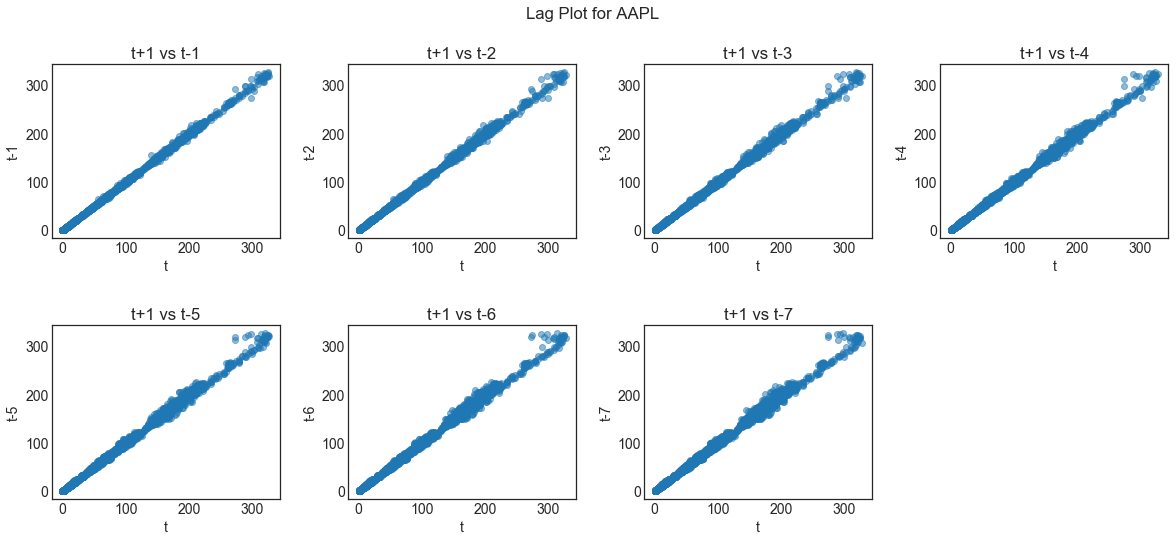

In [41]:
lag_plot_weekly(stock_data, 'AAPL')

<p style="font-size:18px"><b>Explanation:</b></p>

<p style='text-align: justify; margin-right: 20px'> The shape of the lag plot provides clue about the underlying structure of the data; and it this case, the data for all companies exhibit <b>strong positive linear pattern</b> thus implying that the time series are strongly non-random and an autoregressive model is probably a better choice.</p>

<p style='text-align: justify; margin-right: 20px'> Although <b>postitive autocorrelation</b> is present, the strength of the autocorrelation is getting weaker day by day. The first lag has datapoints that are tightly clustered around the diagonal, but the datapoints starting to disperse away from the diagonal at the third lag and beyond. This means that the adjusted closing price in a particular day differs greatly from the price it was at the same day in the previous week.</p>

<p style='text-align: justify; margin-right: 20px'> Presence of <b>outliers</b> can be seen in the AAPL, AMZN, and FB data but insignificant in the ISRG data; whereas <b>none of the data exhibits seasonality</b>. Data with seasonality will repeat itself periodically in a sine or cosine-like wave but in our case, no such patter can be observed.

## Prediction Model <a name="modeling"></a>

### Data Pre-processing

<p style='text-align: justify; margin-right: 20px'> For modeling purpose, we will chose <b>Apple (AAPL)</b> data as it has most datapoints due to longer years of trading and despite  disruptions in society and business caused by the recent coronavirus pandemic has battered the stock market, AAPL is uniquely positioned to perform well. Regarded as one of the Big Four technology companies along with Google, Amazon, and Microsoft, Apple's stock price meteoric rise everytime the company releases its new product.

<p style='text-align: justify; margin-right: 20px'> To recall, the line plot shows the adjusted closing price of AAPL <i>increases in general</i> since its commencement in the U.S stock market.

Text(0.5, 1.0, 'Daily Adjusted Closing Price of AAPL')

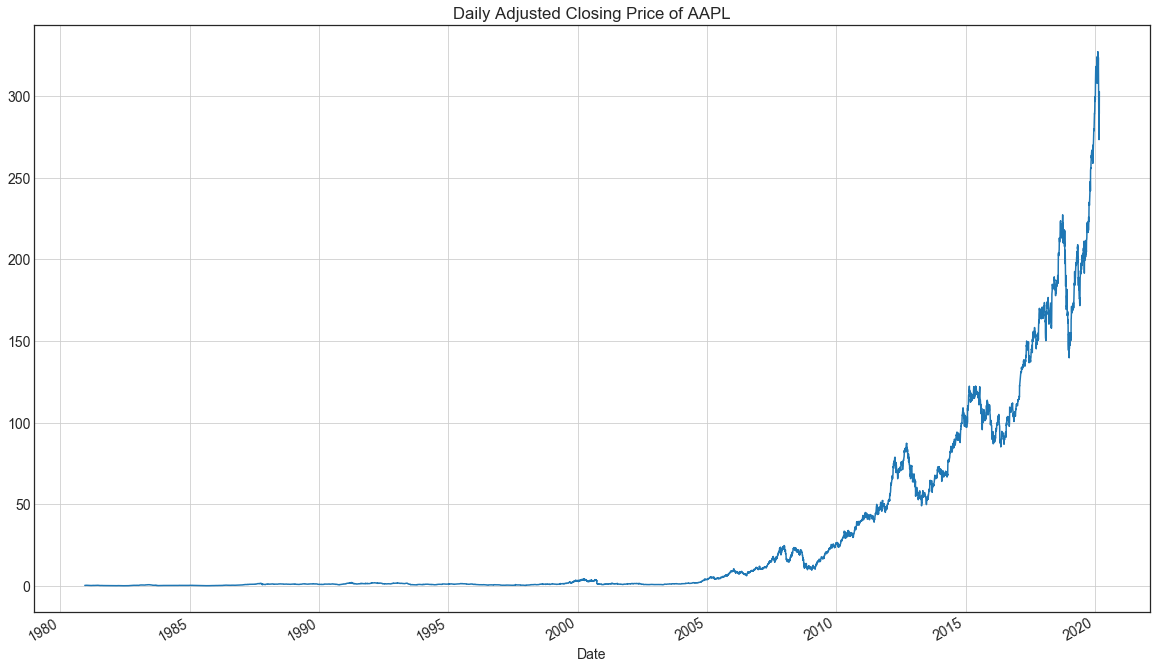

In [42]:
df_adj_close_viz['AAPL'].plot(grid=True)
plt.title('Daily Adjusted Closing Price of AAPL')

<p style='text-align: justify; margin-right: 20px'> However, there is no obvious pattern in the fluctuation of the AAPL stock price. When decomposing the time series into its components i.e. Trend, Seasonal and Residual, AAPL data shows an obvious upward trend but has insignificant seasonality (be it daily or annually) and unstable variance.</p>

#### Components of a time series

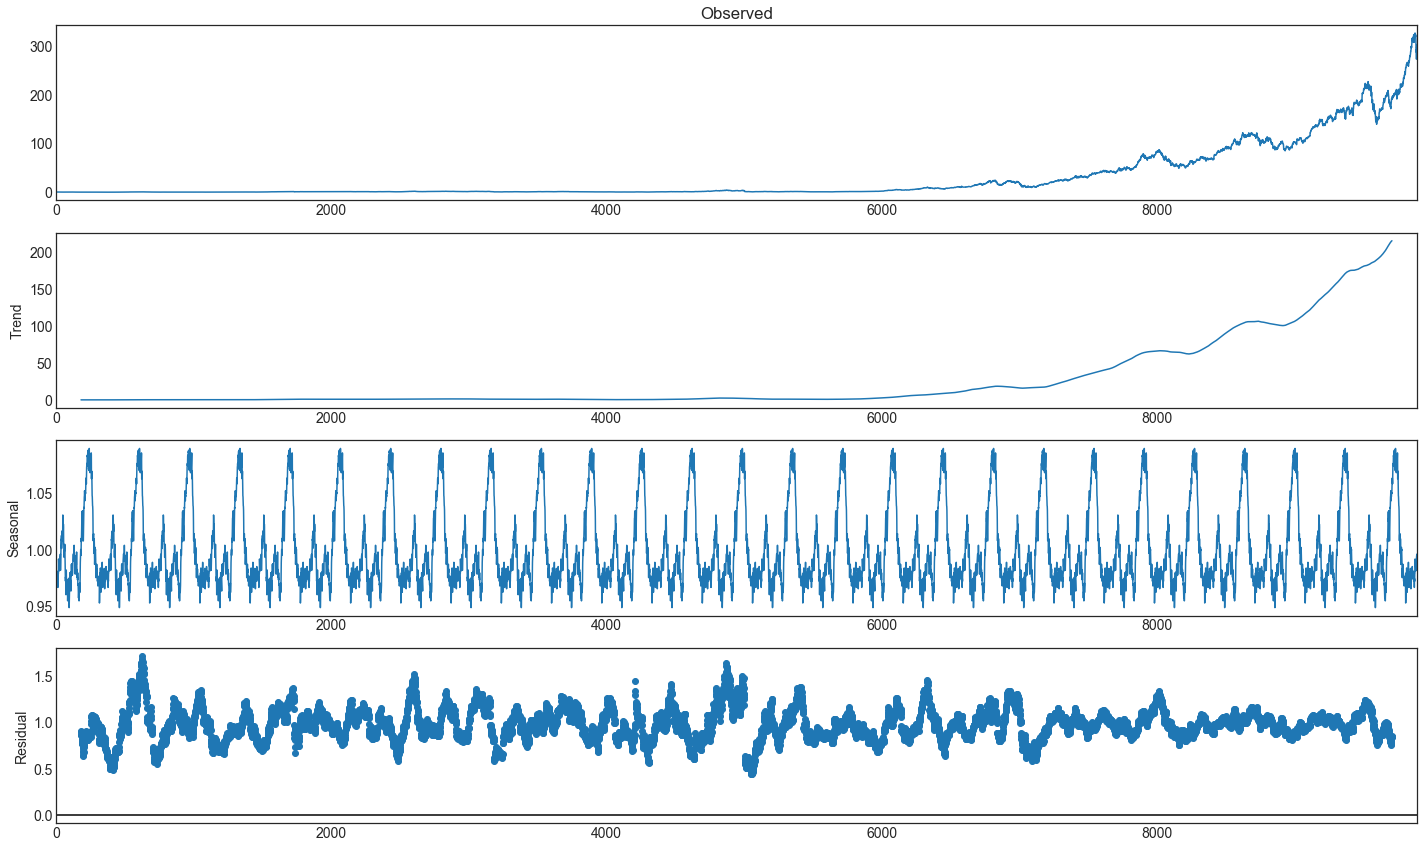

In [43]:
# subset data for the company of interest
company_data = stock_data[stock_data['Symbol']=='AAPL']

# create a new dataframe contain only the 'Adj_Close' column, then convert the dataframe to a series
data = company_data.filter(['Adj_Close'])
series = data.values

# decompose time series into its component
result = seasonal_decompose(series, model='multiplicative', freq=365)
result.plot()
plt.show()

<p style='text-align: justify; margin-right: 20px'> To stabilize the variance in a time series (hence make it stationary), we can use logarithm transformation on the original data. Time series is stationary when its mean and variance are not a function of time (i.e. they are constant through time). Stationarity is important because most of the statistical methods to perform analysis and forecasting work on the assumption that the statistical properties (mean, variance, correlation, etc.) of the series are constant in time. </p>

#### Stationarity of a time series

<p style='text-align: justify; margin-right: 20px'> To test (and measure) the stationarity of a time series, ones need to check how the statistical properties vary in time. This can be done either by visual inspection of the datapoints or by performing <b>Dickey-Fuller test</b> - a statistical test that is normally used in Time Series Analysis to check for the stationarity of a univariate series by deciphering the presence of unit root in the series. Parameters such as <b>p-value</b>, <b>test statistic</b> and <b>crtitical values</b> derived from the test will be used to interpret the test result.</p>

The null and alternate hypothesis of this test are:

> <li><b>H<sub>0</sub>:</b> The time series has a unit root, thus it is non-stationary.</li>
> <li><b>H<sub>a</sub>:</b> The time series has no unit root, thus it is stationary.</li>

Null hypothesis is rejected when `test statistic < critical value`, thus implying that the series is stationary. 

If `test statistic > critical value`, the null hypothesis is failed to be rejected thus the series is regarded as non-stationary.


In [19]:
# define function for ADF test

def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Rolling means (or moving averages) are generally used to smooth out short-term fluctuations in time series data and highlight long-term trends. We use the `rolling()` method with `window = 5` to compute the 5 business-days rolling mean of our daily stock data. 

In [20]:
# define function for testing data stationarity

def stationarity_test(timeseries):
    
    # calculate rolling statistics
    rolmean = timeseries.rolling(window=5).mean()
    rolstd = timeseries.rolling(window=5).std()
    
    # plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    adf_test(timeseries)

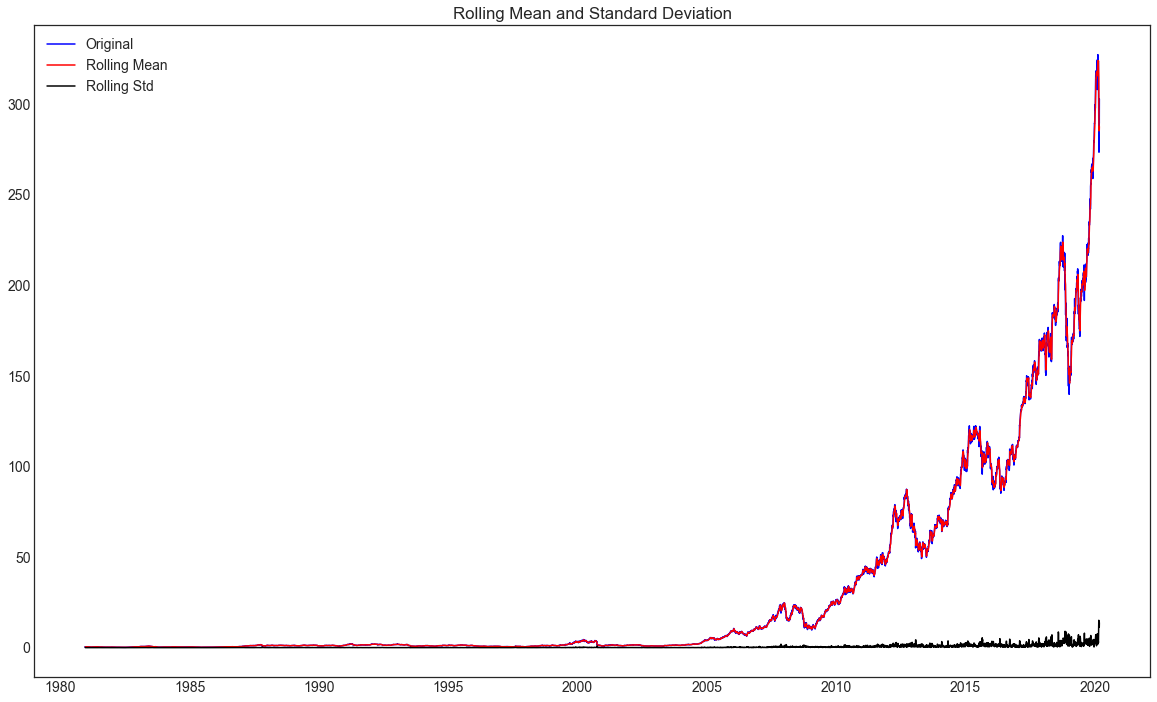

Results of Dickey-Fuller Test:
Test Statistic                    4.684072
p-value                           1.000000
#Lags Used                       37.000000
Number of Observations Used    9851.000000
Critical Value (1%)              -3.431014
Critical Value (5%)              -2.861833
Critical Value (10%)             -2.566926
dtype: float64


In [44]:
# apply function to test data stationarity
stationarity_test(data)

By plotting the `standard deviation` and `mean` along with the original data points, we can see that both are time-dependent. 

**Result:** 
> - **Test Statistic = 2.61** i.e. `test statistic > critical value` 
> - The null hypothesis is failed to be rejected thus clearly implying that the original time series is non-stationary. 

<p style='text-align: justify; margin-right: 20px'> To make a time series  stationary, <b>Transformation</b> and <b>Differencing</b> are the two common methods that can be applied. Trend and seasonality need to be removed from the data and in our case, trend is main culprit that is causing the non-stationarity. </p>

<li>Transformation (log, square root, cube root, etc.) will reduce the trend by penalising higher values more than smaller values.</li>
<li>Differencing method will take the difference of an observation at a particular instant with that at the previous point in time. </li>


<p style='text-align: justify; margin-right: 20px'>  First, let's apply <b>Log Transformation</b> and <b>Moving Average Smoothing</b> to the original time series and check the  stationarity of the output. Application of smoothing technique over the transformed data will remove noise that may be present.</p>

In [22]:
# log-transformed the data
ts_log = np.log(data)

# replace infs with NaN
ts_log.replace([np.inf, -np.inf], np.nan, inplace=True)

# remove all the NaN values
ts_log.dropna(inplace=True)

# get the moving average of the series
moving_avg = ts_log.rolling(5).mean()

# subtract the moving average of the log-transformed dataframe
ts_log_moving_avg_diff = ts_log - moving_avg

# remove all the NaN values
ts_log_moving_avg_diff.dropna(inplace=True)

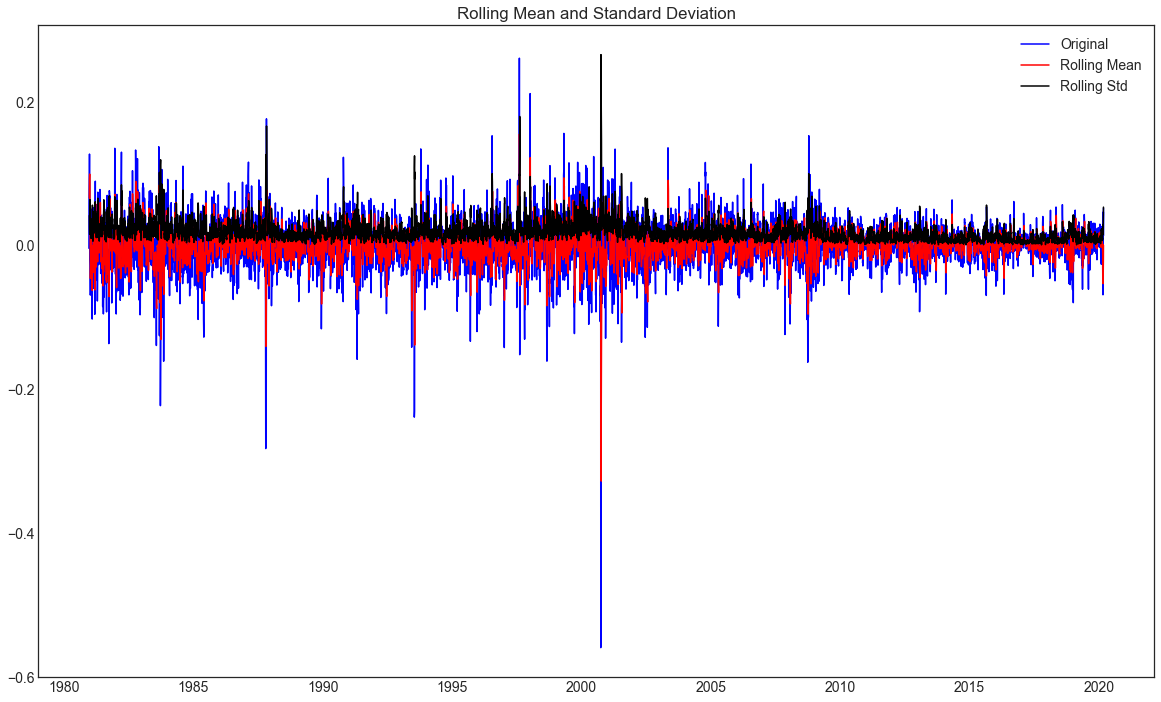

Results of Dickey-Fuller Test:
Test Statistic                  -25.027991
p-value                           0.000000
#Lags Used                       11.000000
Number of Observations Used    9873.000000
Critical Value (1%)              -3.431013
Critical Value (5%)              -2.861833
Critical Value (10%)             -2.566926
dtype: float64


In [45]:
# apply function to test data stationarity on the log-transformed series
stationarity_test(ts_log_moving_avg_diff)

**Result:** 
> - **Test Statistic = -12.09** i.e. `test statistic < critical value`  
> - The null hypothesis is rejected thus implying that the log-transformed time series is stationary. 

Next, let's apply first order Differencing to the log-transformed data and check its stationarity:

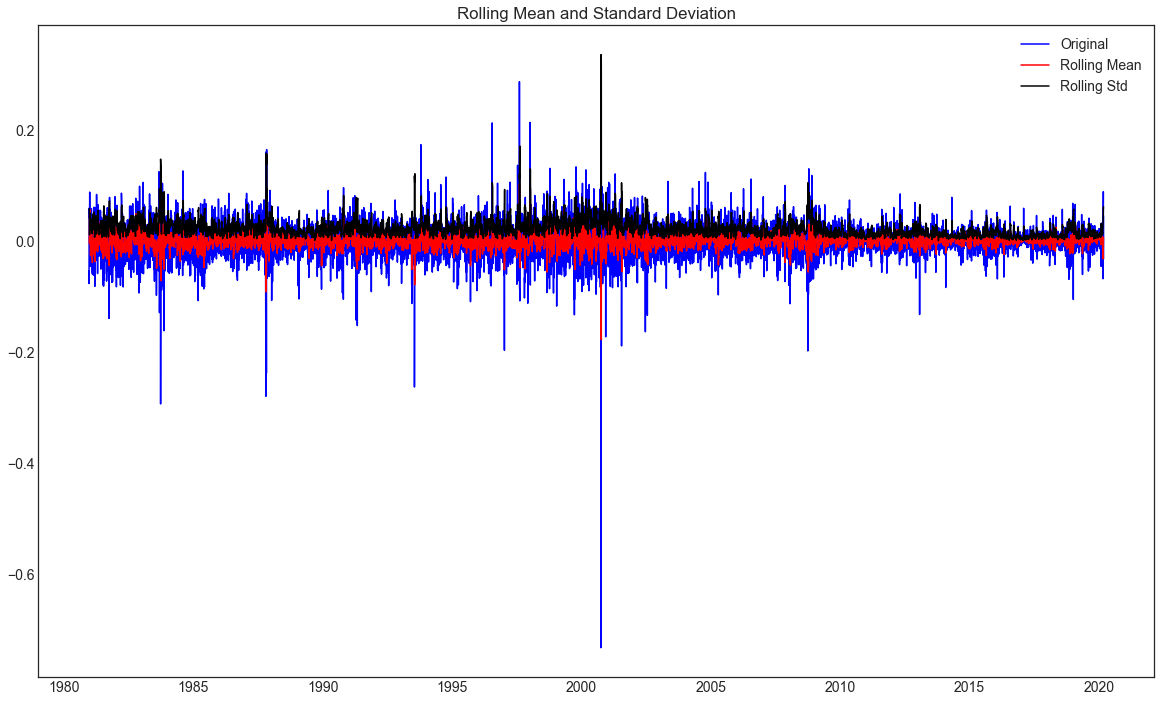

Results of Dickey-Fuller Test:
Test Statistic                  -22.636068
p-value                           0.000000
#Lags Used                       16.000000
Number of Observations Used    9871.000000
Critical Value (1%)              -3.431013
Critical Value (5%)              -2.861833
Critical Value (10%)             -2.566926
dtype: float64


In [46]:
# apply first order differencing to the log-transformed data
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

# apply function to test data stationarity on the differencing series
stationarity_test(ts_log_diff)

**Result:** 
> - **Test Statistic = -12.86** i.e. `test statistic < critical value`  
> - The null hypothesis is rejected thus implying that the time series is stationary. 

With combination of log transformation and differencing, the Test Statistic becomes more negative therefore there is stronger evidence to reject the null hypothesis of a unit root.

### Defining metrics for model evaluation

In [25]:
# define functions to output metrics for model evaluation:

def root_mean_squared_error(actual, pred):
    rmse = np.sqrt(np.mean(pred-actual)**2)
    return rmse

def mean_absolute_percentage_error(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return mape

### Modeling Method 1: Auto-ARIMA

`ARIMA` is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. 

There are three important parameters in ARIMA:

> <li><b>p</b> : the parameter associated with the auto-regressive (AR) aspect of the model, which incorporates past values to forecast the next value.</li>
> <li><b>q</b> : the parameter associated with the moving average (MA) part of the model, which uses past forecast errors to predict the future value.</li>
> <li><b>d</b> : the parameter associated with the integrated (I) part of the model, which is related to the order of differencing to apply to a time series.</li>


[`Auto-ARIMA`](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) automatically selects the best combination of (p,q,d) that provides the least error, plus it does not consume a lot of time than the manual parameter tuning in ARIMA. `Auto-ARIMA` automatically conducts differencing tests (i.e. Augmented Dickey-Fuller (ADF) test) to determine the order of differencing, d, and then fitting models within ranges of defined `start_p`, `max_p`, `start_q`, `max_q` ranges. 

If the seasonal option is enabled, auto-ARIMA also seeks to identify the optimal `P` and `Q` hyper-parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, `D`.

In [55]:
# define function to split train test datasets for Auto-Arima modeling:
  
# Get the number of rows to train the model on
training_data_len = math.ceil(len(data) * .8)

# subset training data
train_data = data[0:training_data_len]

# subset testing data
test_data = data[training_data_len:]

# convert each dataset to a numpy array
train, test = train_data.values, test_data.values

<img src=./images/arima_train_test_split.png>

In [56]:
# initialize Auto-ARIMA model:
model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, 
                   m=12, start_P=0, seasonal=False, d=1, D=1, trace=True, 
                   error_action='ignore', suppress_warnings=True)

# fit model to the training series
model.fit(train)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=762.096, BIC=790.000, Time=3.384 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=790.269, BIC=804.221, Time=0.531 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=785.152, BIC=806.080, Time=0.896 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=785.326, BIC=806.254, Time=0.552 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=797.589, BIC=804.565, Time=0.208 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=773.010, BIC=807.890, Time=3.632 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=772.739, BIC=807.619, Time=3.655 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=786.151, BIC=814.055, Time=1.009 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=786.022, BIC=813.926, Time=1.228 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=757.038, BIC=798.894, Time=7.130 seco

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [57]:
# make predictions based on the fitted model
predictions = model.predict(n_periods = test.shape[0])

In [58]:
# output model metrics for model evaluation
arima_rmse = root_mean_squared_error(test, predictions)
arima_mape = mean_absolute_percentage_error(test, predictions)

output=[]
output.append({'Model': 'Auto-Arima', 'RMSE': arima_rmse, 'MAPE': arima_mape, 'Predictions': predictions})
arima_metrics = pd.DataFrame(output)
arima_metrics

,Model,RMSE,MAPE,Predictions
0,Auto-Arima,49.698489,35.799058,"[69.2334352975805, 69.2701611222995, 69.205991..."


In [60]:
pred_data = pd.DataFrame(predictions, index=test_data.index, columns=['Prediction'])

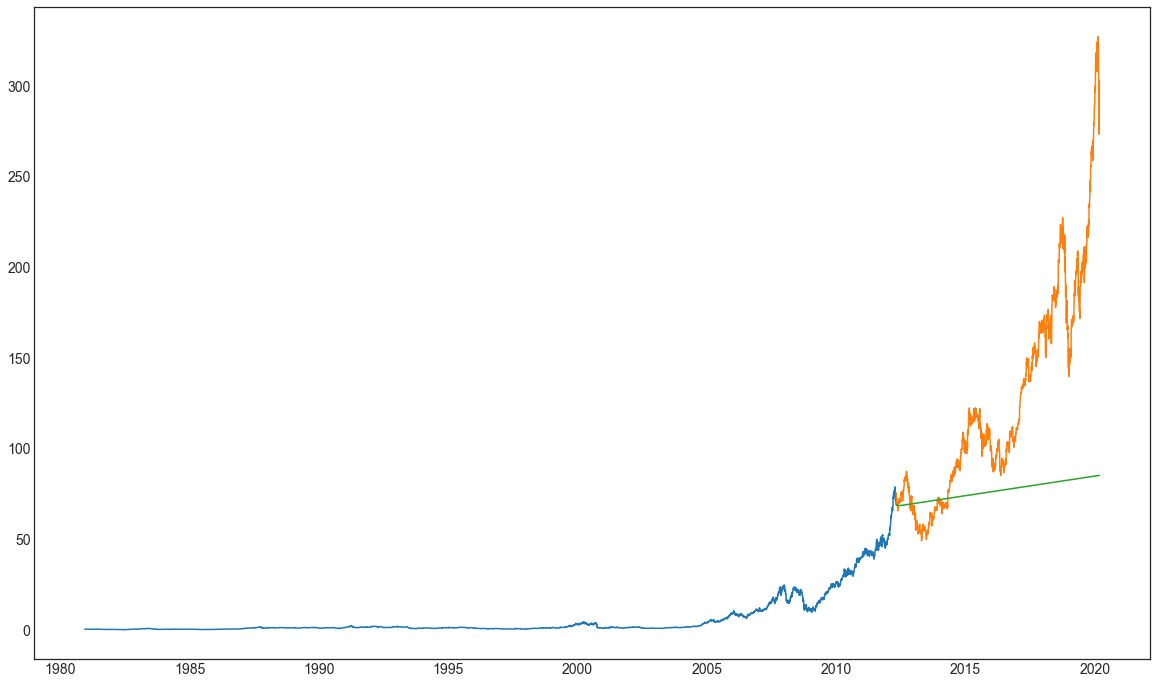

In [61]:
plt.plot(train_data)
plt.plot(test_data)
plt.plot(pred_data)
# plt.title('Auto-ARIMA Prediction')
# plt.xlabel('Date')
# plt.ylabel('Adjusted Closing Price USD ($)')

An auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. Although the predictions using this technique are far better than that of the previously implemented machine learning models, these predictions are still not close to the real values.

As its evident from the plot, the model has captured a trend in the series, but does not focus on the seasonal part. In the next section, we will implement a time series model that takes both trend and seasonality of a series into account.

### Modeling Method 3: Long short-term memory (LSTM)

Long Short Term Memory networks or `LSTM` is a special kind of Recurrent Neural Network (RNN) that is capable of learning long-term dependencies by storing past information that is important, and forgetting the information that is not. LSTMs have been widely used for sequence prediction problems and are proven to be extremely effective. 

In summary, LSTM has three gates that carefully regulate the 'movement' of information in the network:

> <li><b>Input gate</b> adds information to the cell state </li>
> <li><b>Forget gate</b> removes information that is no longer required by the model </li>
> <li><b>Output gate</b> selects the information to be shown as output </li>

Detailed explanation on LSTM concepts are widely available online. 
<img src=./images/LSTM3-focus-f.png>
<img src=./images/LSTM3-focus-C.png>
<img src=./images/LSTM3-focus-i.png>
<img src=./images/LSTM3-focus-o.png>

Source: [LSTM concept](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### Split Train Test Series

In [69]:
# convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# create training dataset
# scale the train data 
train_data = scaled_data[0:training_data_len, :]
# append the past-60-day values to X_train dataset and every 61st-day value to y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
# convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
# reshape X_train dataset
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# create testing dataset
# scale the test data and create X_test and y_test dataset
test_data = scaled_data[training_data_len-60:,:]

# Create the dataset X_test and y_test
X_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

# convert X_test and y_test to numpy array
X_test = np.array(X_test)

# reshape X_test dataset
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

<img src=./images/lstm_train_test_split.png>

In [70]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=4)

Epoch 1/4
7852/7852 [==============================] - 297s 38ms/step - loss: 3.8543e-05
Epoch 2/4
7852/7852 [==============================] - 294s 37ms/step - loss: 1.5117e-05
Epoch 3/4
7852/7852 [==============================] - 294s 37ms/step - loss: 1.0488e-05
Epoch 4/4
7852/7852 [==============================] - 293s 37ms/step - loss: 8.5845e-06


In [71]:
# Get the predicted price value from the model
predictions = model.predict(X_test)

# Transform the scaled predictions to the actual value
predictions = scaler.inverse_transform(predictions)

In [72]:
# output model metrics for model evaluation
lstm_rmse = root_mean_squared_error(y_test, predictions)
lstm_mape = mean_absolute_percentage_error(y_test, predictions)

output=[]
output.append({'Model': 'LSTM', 'RMSE': lstm_rmse, 'MAPE': lstm_mape, 'Predictions': predictions})
lstm_metrics = pd.DataFrame(output)
lstm_metrics

,Model,RMSE,MAPE,Predictions
0,LSTM,0.914604,1.982364,"[[71.33876], [75.88347], [76.82709], [76.30292..."


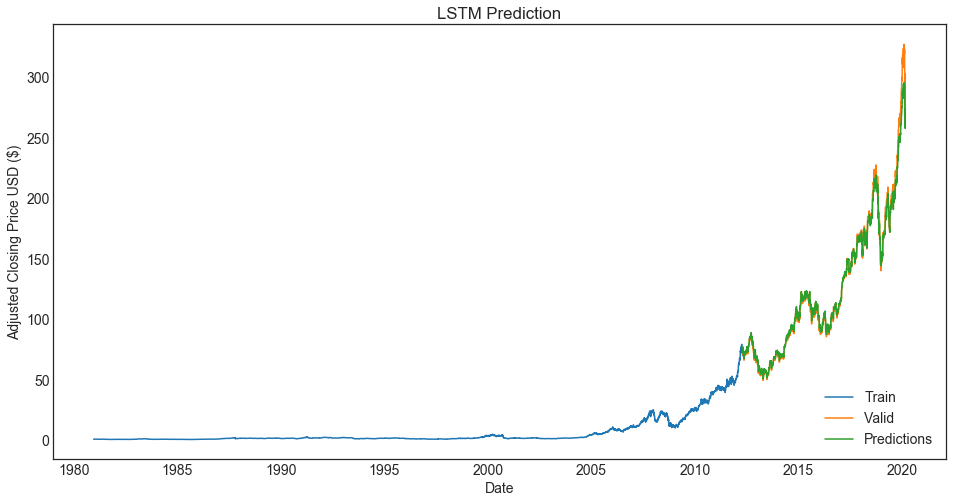

In [73]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualise the data
plt.figure(figsize=(16,8))
plt.title('LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price USD ($)')
plt.plot(train['Adj_Close'])
plt.plot(valid[['Adj_Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

### Model Validation

In comparison to Auto-ARIMA, LSTM gives better predictions; supported by the metrics values:

In [74]:
# dataframe for model metrics
frames = [arima_metrics, lstm_metrics]
compare_metrics = pd.concat(frames).reset_index(drop=True)
compare_metrics

,Model,RMSE,MAPE,Predictions
0,Auto-Arima,49.698489,35.799058,"[69.2334352975805, 69.2701611222995, 69.205991..."
1,LSTM,0.914604,1.982364,"[[71.33876], [75.88347], [76.82709], [76.30292..."


Therefore, we will pick LSTM as the preferred model for model validation:

In [68]:
# Predict the stock price for 2020-02-04

company_subset = data.loc['2010-01-01':'2020-03-02']

# Get the last 60-day closing price values and convert the dataframe to an array
last_60_days = company_subset[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

# Create a list for the the last 60-day
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Fit in the model to get the predicted scaled price
pred_price = model.predict(X_test)

# Unscale the data
pred_price = scaler.inverse_transform(pred_price)
print('2020-03-03')
print(pred_price)

# actual stock price for 2019-12-18 
data.loc['2020-03-02':'2020-03-04']

2020-03-03
[[230.90346]]


,Adj_Close
Date,
2020-03-02,298.809998
2020-03-03,289.320007
2020-03-04,302.739990


## Evaluation and Analysis <a name="analysis"></a>

## References <a name="references"></a>